In [733]:
import numpy as np
import matplotlib.pyplot as plt

# The gyro spins lambda will form part of f, so compute the
# them beforehand
# Note: renaming lambda_dot to spin

class Properties:
    
    def __init__(self, AT=0, BT=0, CT=0, CR=0):
        self.AT = AT
        self.BT = BT
        self.CT = CT
        self.CR = CR
        
    def unpack(self):
        return self.AT, self.BT, self.CT, self.CR
    
    
class Conditions:
    
    def __init__(self, omega_initial=None,
                 get_spin = lambda t: np.zeros(3),
                 get_spin_acc = lambda t: np.zeros(3)):
        self.omega_initial = omega_initial
        self.get_spin = get_spin
        self.get_spin_acc = get_spin_acc

    def unpack(self):
        return self.omega_initial, self.get_spin, self.get_spin_acc
    
    
def simulate(properties, conditions, T, N):
    
    AT, BT, CT, CR = properties.unpack()
    omega_initial, get_spin, get_spin_acc = conditions.unpack()
    
    def f(t, omega):
        
        spin = get_spin(t)
        spin_acc = get_spin_acc(t)

        omega_1_acc = -(1/AT)*(CR*spin_acc[0] + (CT-BT)*omega[1]*omega[2]
                           + CR*(omega[1]*spin[2] - omega[2]*spin[1]))
        omega_2_acc = -(1/BT)*(CR*spin_acc[1] + (AT-CT)*omega[0]*omega[2]
                           + CR*(omega[2]*spin[0] - omega[0]*spin[2]))
        omega_3_acc = -(1/CT)*(CR*spin_acc[2] + (BT-AT)*omega[0]*omega[1]
                           + CR*(omega[0]*spin[1] - omega[1]*spin[0]))

        return np.array([omega_1_acc, omega_2_acc, omega_3_acc])
    
    omega = np.zeros((N, 3))
    omega[0] = omega_initial

    t = np.linspace(0, T, N)
    dt = T/(N-1)

    for n in range(N-1):
        k1 = f(t[n], omega[n])
        k2 = f(t[n] + dt/2, omega[n] + k1*dt/2)
        k3 = f(t[n] + dt/2, omega[n] + k2*dt/2)
        k4 = f(t[n] + dt, omega[n] + k3*dt)

        omega[n+1] = omega[n] + (1/6)*(k1 + 2*k2 + 2*k3 + k4)*dt

    return t, omega, \
           np.array([get_spin(ti) for ti in t]), \
           np.array([get_spin_acc(ti) for ti in t])

def plot_simulation(t, omega, spin, name=None):
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9, 5))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.25)

    ax0.plot(t, spin[:, 0], label=r'$\omega_1$')
    ax0.plot(t, spin[:, 1], label=r'$\omega_2$')
    ax0.plot(t, spin[:, 2], label=r'$\omega_3$')

    ax0.legend(fontsize=14)
    ax0.set_xlabel('Time t (s)', fontsize=14)
    ax0.set_ylabel(r'$\mathbf{\omega}$ (rad/s)', fontsize=14)

    ax1.plot(t, omega[:, 0], label=r'$\Omega_1$')
    ax1.plot(t, omega[:, 1], label=r'$\Omega_2$')
    ax1.plot(t, omega[:, 2], label=r'$\Omega_3$')
    ax1.legend(fontsize=14)
    ax1.set_xlabel('Time t (s)', fontsize=14)
    ax1.set_ylabel(r'$\mathbf{\Omega}$ (rad/s)', fontsize=14)
    
    if name is not None:
        plt.savefig('../fig/{}'.format(name), bbox_inches='tight')
    plt.show()

In [734]:

def build_constant_spin(spin1, spin2, spin3):
    get_spin = lambda t: np.array([spin1, spin2, spin3])
    get_spin_acc = lambda t: np.array([0, 0, 0])
    return get_spin, get_spin_acc

def build_spin_ramp(index, change, start, length):
    def get_spin(t):
        if t<start:
            spin = 0
        elif t<start+length:
            spin = change*(t-start)/length
        else:
            spin = change
        spins = np.zeros(3)
        spins[index] = spin
        return spins
    
    def get_spin_acc(t):
        if t>start and t<start+length:
            spin_acc = change/length
        else:
            spin_acc = 0
        spin_accs = np.zeros(3)
        spin_accs[index] = spin_acc
        return spin_accs
    
    return get_spin, get_spin_acc

def combine_pairs(*pairs):
    def get_spin(t):
        total = 0
        for pair in pairs:
            total += pair[0](t).astype(float)
        return total
    
    def get_spin_acc(t):
        total = 0
        for pair in pairs:
            total += pair[1](t).astype(float)
        return total
    
    return get_spin, get_spin_acc


# Constant spin, no rotation

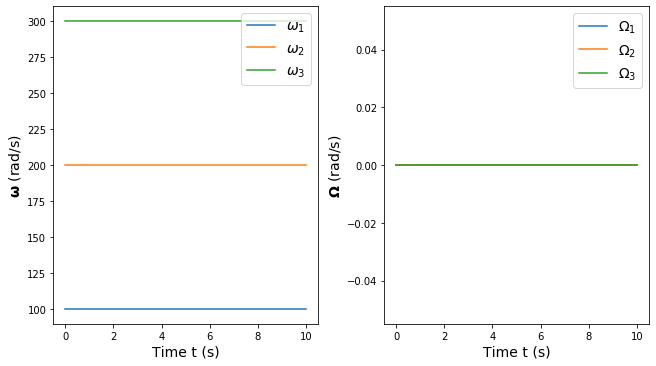

In [735]:
properties = Properties(100, 150, 200, 10)

T = 10
N = 100

omega_initial = np.zeros(3)
get_spin, get_spin_acc = build_constant_spin(100, 200, 300)
conditions = Conditions(omega_initial, get_spin, get_spin_acc)

t, omega, spin, spin_acc = simulate(properties, conditions, T, N)

plot_simulation(t, omega, spin, 'reaction_single_stationary.png')

# Motion about a single axis

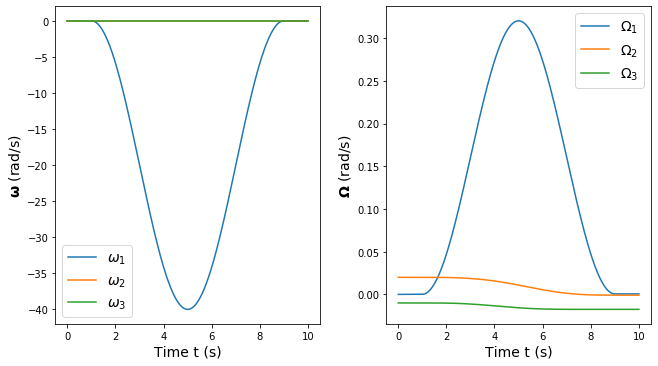

In [746]:
properties = Properties(100, 150, 200, 0.5)

T = 10
N = 1000

omega_initial = np.array([0, 0.02, -0.01])

def get_spin(t):
    if t<1 or t>9:
        return np.zeros(3)
    else:
        spin1 = 20*(np.cos(2*np.pi*(t-1)/8)-1)
        return np.array([spin1, 0, 0])
    
def get_spin_acc(t):
    if t<1 or t>9:
        return np.zeros(3)
    else:
        spin1_acc = -20*(2*np.pi/5)*np.sin(2*np.pi*(t-1)/8)
        return np.array([spin1_acc, 0, 0])
    
conditions = Conditions(omega_initial, get_spin, get_spin_acc)

t, omega, spin, spin_acc = simulate(properties, conditions, T, N)

plot_simulation(t, omega, spin, 'reaction_single_zero_stable.png')

# Unstable motion about a single axis

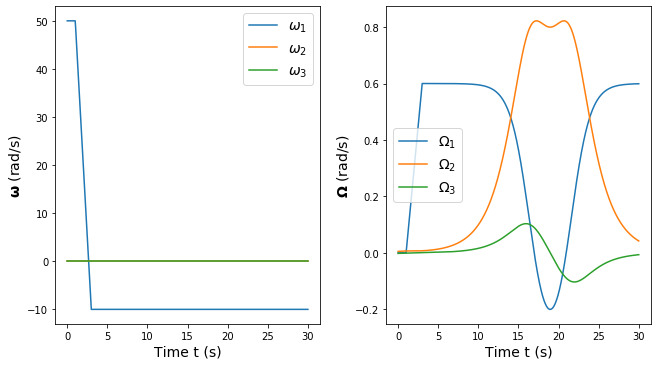

In [744]:
properties = Properties(100, 50, 300, 1)

T = 30
N = 1000


# The station has some initial angular velocity, which in order to make the station stationary, has
# required all gyroscopes to have some spin
# Following this, a rotation about axis 1 is desired.

omega_initial = np.array([0, 0.005, -0.002])

get_spin, get_spin_acc = combine_pairs(
    build_constant_spin(50, 0, 0),
    build_spin_ramp(0, -60, 1, 2)
)

conditions = Conditions(omega_initial, get_spin, get_spin_acc)

t, omega, spin, spin_acc = simulate(properties, conditions, T, N)

plot_simulation(t, omega, spin, 'reaction_single_zero_unstable.png')

# Attempted rotation about a single axis by changing a single reaction wheel spin, while the other reaction wheels are spinning

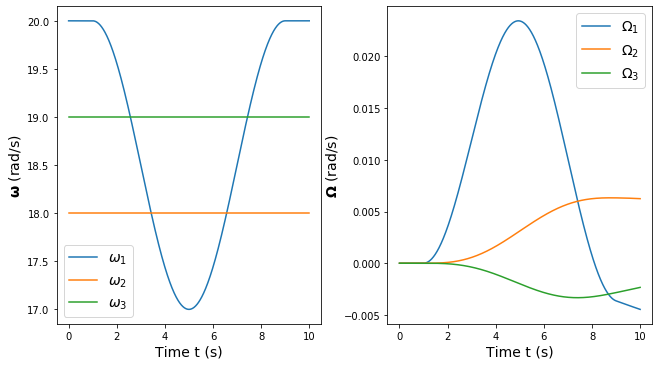

In [743]:
properties = Properties(100, 150, 200, 0.5)

T = 10
N = 1000


# The station has some initial angular velocity, which in order to make the station stationary, has
# required all gyroscopes to have some spin
# Following this, a rotation about axis 1 is desired.

omega_initial = np.array([0, 0, 0])

def get_spin(t):
    if t<1 or t>9:
        return np.zeros(3)
    else:
        spin1 = 1.5*(np.cos(2*np.pi*(t-1)/8)-1)
        return np.array([spin1, 0, 0])
    
def get_spin_acc(t):
    if t<1 or t>9:
        return np.zeros(3)
    else:
        spin1_acc = -1.5*(2*np.pi/5)*np.sin(2*np.pi*(t-1)/8)
        return np.array([spin1_acc, 0, 0])
    
get_spin, get_spin_acc = combine_pairs(
    build_constant_spin(20, 18, 19),
    (get_spin, get_spin_acc)
)

conditions = Conditions(omega_initial, get_spin, get_spin_acc)

t, omega, spin, spin_acc = simulate(properties, conditions, T, N)

plot_simulation(t, omega, spin, 'reaction_naive_attempt.png')

# Countering precession by "precessing" rotor spins in opposite direction

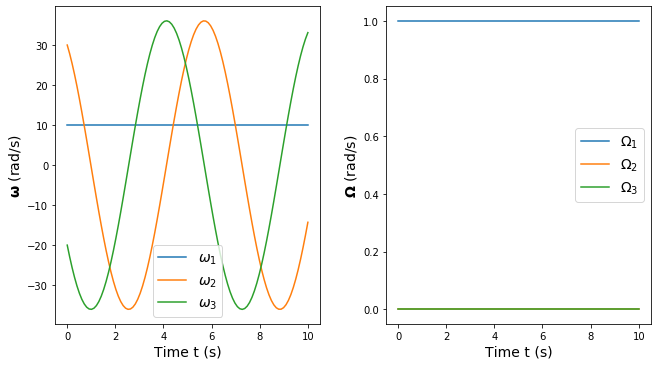

In [740]:
properties = Properties(100, 150, 200, 0.5)
AT, BT, CT, CR = properties.unpack()

T = 10
N = 100

omega1 = 1
omega2 = 0
omega3 = 0
omega_initial = np.array([omega1, omega2, omega3])
initial_spin = np.array([10.0, -20.0, 30.0])

def get_spin(t):
    spin1 = initial_spin[0]
    A = np.sqrt(initial_spin[1]**2 + initial_spin[2]**2)
    phi = np.arctan2(initial_spin[2], initial_spin[1])
    spin2 = A*np.sin(omega1*t + phi)
    spin3 = A*np.cos(omega1*t + phi)
    return np.array([spin1, spin2, spin3])
    
def get_spin_acc(t):
    spin1 = 0
    A = np.sqrt(initial_spin[1]**2 + initial_spin[2]**2)
    phi = np.arctan2(initial_spin[2], initial_spin[1])
    spin2 = omega1*A*np.cos(omega1*t + phi)
    spin3 = -omega1*A*np.sin(omega1*t + phi)
    return np.array([spin1, spin2, spin3])
    
    
conditions = Conditions(omega_initial, get_spin, get_spin_acc)

t, omega, spin, spin_acc = simulate(properties, conditions, T, N)

plot_simulation(t, omega, spin, 'reaction_smart_constant.png')

# Using the above for controlled rotation


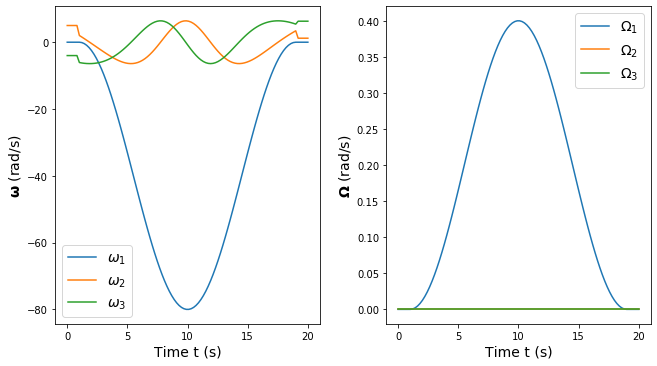

In [741]:
properties = Properties(100, 150, 200, 0.5)
AT, BT, CT, CR = properties.unpack()

T = 20
N = 100

omega_initial = np.array([0, 0, 0])
initial_spin = np.array([0, -4, 5])

def get_delta_spin1_derivative(t):
    if t<1 or t>19:
        return 0
    else:
        return -(2*np.pi/18)*40*np.sin(2*np.pi*(t-1)/18)

def get_delta_spin1(t):
    if t<1 or t>19:
        return 0
    else:
        return 40*(np.cos(2*np.pi*(t-1)/18)-1)

def get_delta_spin1_integral(t):
    if t<1:
        return 0
    elif t<19:
        return (18/(2*np.pi))*40*(np.sin(2*np.pi*(t-1)/18)-t)
    else:
        return (18/(2*np.pi))*40*(np.sin(2*np.pi*(18-1)/18)-18)
    
def get_omega1(t):
    return - (CR/AT)*get_delta_spin1(t) + omega_initial[0]

def get_omega1_integral(t):
    return - (CR/AT)*get_delta_spin1_integral(t) + omega_initial[0]*t

def get_spin(t):
    spin1 = get_delta_spin1(t) + initial_spin[0]
    A = np.sqrt(initial_spin[1]**2 + initial_spin[2]**2)
    phi = np.arctan2(initial_spin[2], initial_spin[1])
    theta = get_omega1_integral(t)
    spin2 = A*np.sin(theta + phi)
    spin3 = A*np.cos(theta + phi)
    return np.array([spin1, spin2, spin3])
    
def get_spin_acc(t):
    spin1 = get_delta_spin1_derivative(t)
    A = np.sqrt(initial_spin[1]**2 + initial_spin[2]**2)
    phi = np.arctan2(initial_spin[2], initial_spin[1])
    omega1 = get_omega1(t)
    theta = get_omega1_integral(t)
    spin2 = omega1*A*np.cos(theta + phi)
    spin3 = -omega1*A*np.sin(theta + phi)
    return np.array([spin1, spin2, spin3])
    
    
conditions = Conditions(omega_initial, get_spin, get_spin_acc)

t, omega, spin, spin_acc = simulate(properties, conditions, T, N)

plot_simulation(t, omega, spin, 'reaction_smart_variable.png')